In [3]:
from d2l import torch as d2l
import torch
import torch.nn as nn
import torch.nn.functional as F
import re
import os
import collections
import math

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"  #不加这句画图内核会挂掉

# 数据读取

In [4]:
def read_zjl():
    with open('./data/zjl.txt', 'r',  encoding='UTF8') as f:
        lines = f.readlines()
        #非中文全都替换空格
        return [re.sub('[^\u4e00-\u9fa5]+', ' ', line).strip() for line in lines]

lines = read_zjl()
print(f'# 文本总行数: {len(lines)}')
print(lines[0])
print(lines[10])

# 文本总行数: 6016
作词 黄俊郎
没有句点 跨时代蔓延翼朝天


# 数据预处理， 词序化

In [5]:
def tokenize(lines):
    '''以汉字为token'''
    return [list(line) for line in lines]

tokens = tokenize(lines)
tokens[0:5], len(tokens)

([['作', '词', ' ', '黄', '俊', '郎'],
  ['作', '曲', ' ', '周', '杰', '伦'],
  ['编', '曲', ' ', '黄', '雨', '勛'],
  ['鐘', '逆', '时', '鐘', '而', '绕', ' ', '恶', '物', '狰', '狞', '的', '倾', '巢'],
  ['我', '谦', '卑', '安', '静', '的', '於', '城', '堡', '下', '的', '晚', '祷']],
 6016)

In [6]:
class Vocab:  
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序, 方便cache和下面的break
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property        
    def unk(self):  
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [7]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), (' ', 1), ('的', 2), ('我', 3), ('你', 4), ('不', 5), ('一', 6), ('在', 7), ('是', 8), ('了', 9)]


In [8]:
for i in [0, 10]:
    print('文本：',tokens[i])
    print('索引', vocab[tokens[i]])

文本： ['作', '词', ' ', '黄', '俊', '郎']
索引 [176, 338, 1, 315, 1267, 1416]
文本： ['没', '有', '句', '点', ' ', '跨', '时', '代', '蔓', '延', '翼', '朝', '天']
索引 [21, 10, 460, 118, 1, 985, 48, 276, 794, 795, 796, 507, 26]


In [9]:
def load_corpus_zjl(tokens, vocab, max_token=-1):
    corpus = [vocab[token] for line in tokens for token in line]
    if max_token > 0:
        return corpus[0: max_token]
    return corpus

corpus = load_corpus_zjl(tokens, vocab)
corpus[0]

176

# 定义数据集并加载

In [10]:
class SeqDataLoader:
    def __init__(self, tokens, vocab, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus= load_corpus_zjl(tokens, vocab, max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps
    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)


def load_data_zjl(tokens, vocab, batch_size, num_steps,  use_random_iter=True, max_tokens=10000):
    """返回周杰伦歌词的训练数据集的迭代器"""
    data_iter = SeqDataLoader(
            tokens, vocab,batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter


batch_size, num_steps = 32, 168
train_iter = load_data_zjl(tokens, vocab, batch_size, num_steps)

# 定义模型并训练

In [11]:
class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

In [12]:
def grad_clipping(net, theta): 
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [13]:
def train_epoch(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        updater.zero_grad()
        l.backward()
        grad_clipping(net, 1)
        updater.step()
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [14]:
def predict(prefix, num_preds, net, vocab, device):  
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])


In [15]:
def train(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=True):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    updater = torch.optim.SGD(net.parameters(), lr)
    pred = lambda prefix: predict(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(pred('你要离开我知道很简单'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')

困惑度 1.6, 257377.4 词元/秒 cuda:0


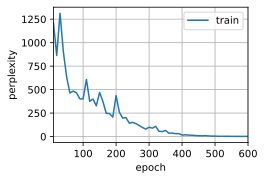

In [16]:
num_inputs, num_hiddens, device, lr, num_epochs = len(vocab), 256, d2l.try_gpu(), 5, 600
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = RNNModel(gru_layer, len(vocab))
model = model.to(device)

train(model, train_iter, vocab, lr, num_epochs, device)

# 预测

In [21]:
predict('你要离开我知道很困难', 200, model, vocab, device)

'你要离开我知道很困难也能不能就要样了一下代表我还在意被我看见你上他的车 这么不小心喇叭按了两声代表我会离去你放心 我理解这游戏呼啸而过的引擎声 是你最讨厌的旋律穿梭在城市中 变成一首幻想曲一边疯狂记录 一边璀璨的忘记忘记 忘记 忘记 忘记你发脾气 甩上车门 香味留在车里对不起 要走可以 关门别太大力用点心 你说不是用来吃的点心冰淇淋 溶化了谎言在你身边的美丽没有了雨 雨刷开始不停左右就像回忆 开始对我挥了挥了手仪表板转动 在猜我会不会懂速度再快也追不回承诺车窗摇下 听你听你完美借口音乐开大 让我让我假装感动贴心的你 不用自导自演心痛我看不懂 我会更难过作词 周杰伦作曲 周杰伦编曲 鐘兴民地上断了翅的蝶 雾散之后的满月原来爱跟心碎 都可以我全腔盯人防守 篮下禁区游走快攻抢篮板球 得分都靠我你拿着球不投 又不会掩护我选你这种队友 瞎透了我说你说 分数怎么停留一直在停留 谁让它停留的为什么我女朋友场外加油你却还让我出糗你说啊 你怎么抄我球你说啊 是不是你不想活说你怎么面对我 甩开球我满腔的怒火我想揍你已经很久 别想躲说你眼睛看着我 别发抖快给我抬起头 有话去对医药箱说别怪我别怪我说你怎么面对我 甩开球我满腔的怒火我想揍你已经很久 别想躲说你眼睛看着我 别发抖快给我抬起头 有话去对医药箱说别怪我别怪我说你怎么面对我 甩开球我满腔的怒火我想揍你已经很久 别想躲说你眼睛看着我 别发抖快给我抬起头 有话去对医药箱说别怪我别怪我说你怎么面对我 甩开球我满腔的怒火我想揍你已经很久 别想躲说你眼睛看着我 别发抖快给我抬起头 有话去对医药箱说别怪我别怪我说你怎么面对我 甩开球我满腔的怒火我想揍你已经很久 别想躲说你眼睛看着我 别发抖快给我抬起头 有话去对医药箱说别怪我别怪我说你怎么面对我 甩开球我满腔的怒火我想揍你已经很久 别想躲说你眼睛看着我 别发抖快给我抬起头 有话去对医药箱说别怪我别怪我说你怎么面对我 甩开球我满腔的怒火我想揍你已经很久 别想躲说你眼睛看着我 别发抖快给我抬起头 有话去对医药箱说别怪我别怪我说你怎么面对我 甩开球我满腔的怒火我想揍你已经很久 别想躲说你眼睛看着我 别发抖快给我抬起头 有话去对医药箱说别怪我别怪我说你怎么面对我 甩开球我满腔的怒火我想揍你已经很久 别想躲说你眼睛看着我 别发抖快给我抬起头 有话去对医药箱说别怪我别怪我说你怎么面对我 甩开球我满腔的怒火